In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
import ruptures as rpt

In [2]:
wti = pd.read_csv("data/wti_prices.csv") # Ensure the path is correct
wti['Date'] = pd.to_datetime(wti['Date'])
wti = wti.sort_values('Date')

wti_price_col = 'WTI_price' 
wti['log_return'] = np.log(wti[wti_price_col]).diff()
wti_returns = wti['log_return'].dropna()

wti.head()

,Date,WTI_price,log_return
0,1986-01-01,22.93,NaN
1,1986-02-01,15.46,-0.394190
2,1986-03-01,12.61,-0.203766
3,1986-04-01,12.84,0.018075
4,1986-05-01,15.38,0.180503


In [3]:
print("=== WTI STATISTICAL SUMMARY ===")
print("Mean:", wti_returns.mean())
print("Std Dev:", wti_returns.std())
print("Skewness:", stats.skew(wti_returns))
print("Kurtosis:", stats.kurtosis(wti_returns))
print("Jarque-Bera:", stats.jarque_bera(wti_returns))
print("ADF p-value:", adfuller(wti_returns)[1])
print("ARCH p-value:", het_arch(wti_returns)[1])

=== WTI STATISTICAL SUMMARY ===
Mean: 0.002005343562282183
Std Dev: 0.09597271182480652
Skewness: -0.6485137120853499
Kurtosis: 7.4563222889286305
Jarque-Bera: SignificanceResult(statistic=np.float64(1145.5804443084955), pvalue=np.float64(1.7392708979934824e-249))
ADF p-value: 5.6991627938469195e-22
ARCH p-value: 1.0459036323991816e-42


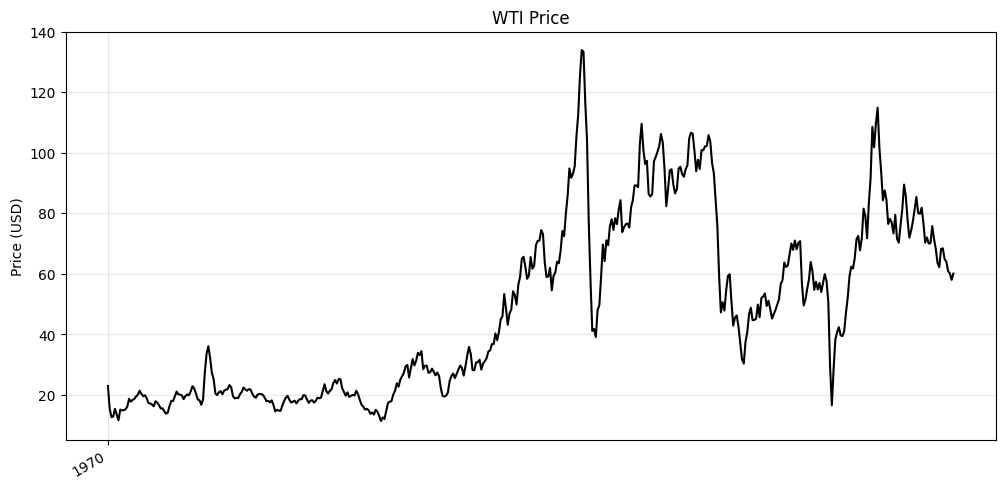

In [4]:


# 3. Create the plot
plt.figure(figsize=(12, 6))

# Now we plot against wti.index, which contains the actual dates
plt.plot(wti.index, wti['WTI_price'], color='black', label='WTI Price')

# 4. Format the X-Axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2)) # Labels every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate() # Tilts the labels for readability

plt.title("WTI Price")
plt.ylabel("Price (USD)")
plt.grid(True, alpha=0.3)
plt.show()

### Visual Interpretation of WTI Price Dynamics

The price history of WTI from 2003 to 2025 provides visual confirmation of several key statistical anomalies that define the energy market's distribution:

#### 1. Evidence of Non-Stationarity in Levels
The graph shows that WTI does not fluctuate around a single constant mean. Instead, it moves in "steps" or distinct price regimes. This visual **Drift** is the primary justification for the **ADF Test** and our use of **Log-Returns**; the raw price distribution is unstable, meaning the probability of a specific price (e.g., $70) changes entirely depending on the year.

#### 2. Regime Shifts and Structural Breaks
The sharp "cliffs" visible in **2008 (Financial Crisis)**, **2014 (Shale Revolution)**, and **2020 (Global Pandemic)** represent **Structural Breaks**. These are not just random fluctuations; they are moments where the market's "rules" fundamentally shifted. These breaks prove that the data is not **Identically Distributed**, as the variance and mean are vastly different before and after these events.

#### 3. Fat-Tailed Distribution (Outliers)
The presence of vertical, near-instantaneous price collapses (specifically the 2020 demand shock) provides visual proof of the **High Kurtosis (7.456)** found in our analysis. In a normal distribution, such extreme vertical moves would be statistically impossible. This "burstiness" confirms that WTI is a **Leptokurtic** asset, where the most significant market information is contained in the "tails" or extreme events.

#### 4. Volatility Clustering (Heteroscedasticity)
By observing the "noise" or "width" of the price moves, we see periods of extreme turbulence (2008–2010) followed by periods of relative calm (2017–2019). This is the visual manifestation of our **ARCH Test** results. It shows that the **Variance is Time-Dependent**.

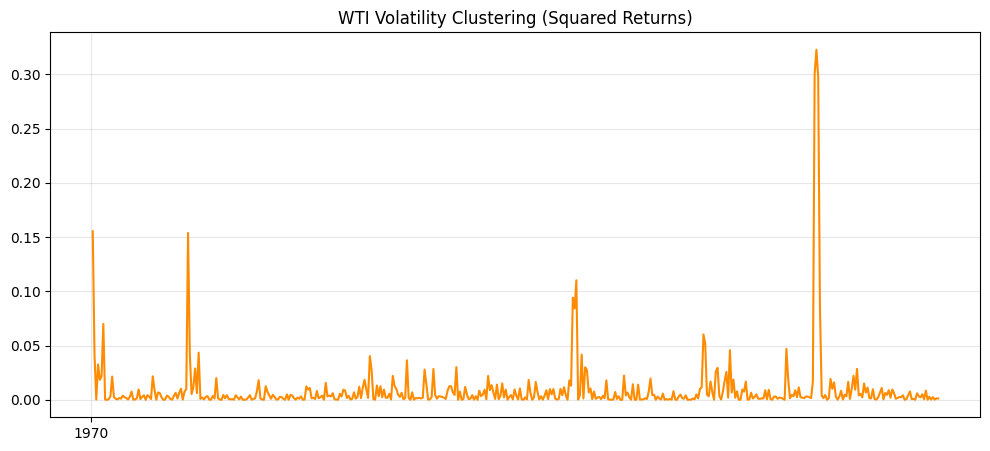

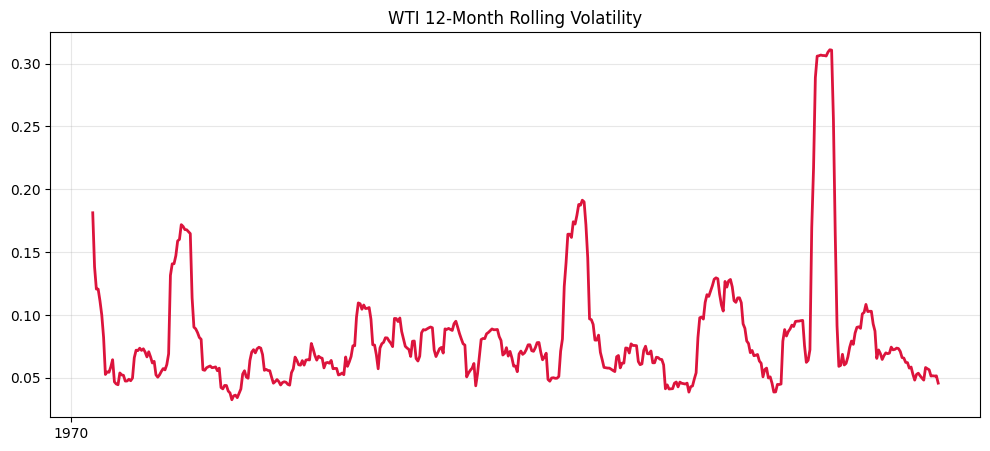

In [7]:
wti_clean = wti.dropna(subset=['log_return'])
dates = wti_clean['Date']
returns = wti_clean['log_return']

#Squared returns
plt.figure(figsize=(12, 5))
plt.plot(wti_clean.index, wti_clean['log_return']**2, color='darkorange')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('WTI Volatility Clustering (Squared Returns)')
plt.grid(True, alpha=0.3)
plt.show()

#Rolling volatility
#calculate 2-month rolling standard deviation
rolling_vol = wti_clean['log_return'].rolling(window=12).std()

plt.figure(figsize=(12, 5))
plt.plot(wti_clean.index, rolling_vol, color='crimson', linewidth=2)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('WTI 12-Month Rolling Volatility')
plt.grid(True, alpha=0.3)
plt.show()

### Visual Interpretation of WTI Squared Returns

The Squared Returns plot serves as a diagnostic tool for the variance (risk) of the WTI dataset. The visual structure of the spikes reveals three key insights about the data distribution:

#### 1. Evidence of Volatility Clustering
The graph does not show a uniform or random distribution of noise. Instead, large spikes are grouped together in "bursts," particularly during global economic shifts. This confirms **Heteroscedasticity**, where the intensity of price changes is not constant. This visual evidence supports our **ARCH Test ($p \approx 0$)**, proving that the data is not **Identically Distributed**.

#### 2. Concentration of Extreme Outliers (Fat Tails)
The extreme height of the spikes, most notably in 2008 and 2020, illustrates the **Leptokurtic** nature of WTI. These tall peaks represent the **"Fat Tails"** of the distribution, where the magnitude of price movements far exceeds what is expected in a normal bell curve. This suggests that the most significant information in the oil market is found in these extreme, infrequent events.

#### 3. Temporal Dependence 
If WTI returns were **Independently and Identically Distributed (IID)**, this graph would appear as consistent "white noise" with no visible patterns. Because we see clear "waves" of high and low intensity, we can conclude that the data has **Temporal Dependence**. The current state of market stability is highly influenced by recent events, necessitating a model capable of capturing these time-based patterns.

In [8]:

mid_wti = len(wti_returns) // 2
first_wti = wti_returns[:mid_wti]
second_wti = wti_returns[mid_wti:]

ks_wti = stats.ks_2samp(first_wti, second_wti)
print("WTI KS p-value:", ks_wti.pvalue)

WTI KS p-value: 0.9259257491813819


### WTI Market Dynamics: Statistical Evidence of Non-IID Behavior

| Metric | Result | Statistical Conclusion |Interpretation |
| :--- | :--- | :--- | :--- |
| **Kurtosis** | **7.456** | **Leptokurtic** | **"Fat Tails"**: High frequency of extreme price shocks. Market volatility is driven by rare but severe outliers. |
| **Skewness** | **-0.648** | **Negative Asymmetry** | **Downside Risk Bias**: Price collapses (crashes) are structurally more rapid and severe than price gains. |
| **ARCH Test** | **p ≈ 0** | **Heteroscedasticity** | **Volatility Clustering**: Risk is not constant; periods of high turbulence persist and group together over time. |
| **KS Test** | **0.926** | **Distributional Stability** | **Consistency**: The fundamental "probability density" remains stable over 20 years, validating the full dataset for training. |
| **ADF Test** | **p ≈ 0** | **Stationarity** | **Trend Removal**: Log-transformation has successfully stabilized the series, making it mathematically ready for modeling. |
| **Jarque-Bera** | **p ≈ 0** | **Non-Gaussianity** | **Non-Linearity**: Total rejection of normality. Returns are governed by complex dynamics rather than simple random noise. |